# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [16]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

In [4]:
# Select the resource to download
url = "https://en.wikipedia.org/wiki/List_of_Spotify_streaming_records"

WITH BEAUTIFUL SOUP

In [6]:
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find all tables
table = soup.find_all('table', {'class': 'wikitable'})[0]  # Gets first wikitable

# Convert to DataFrame
dfb = pd.read_html(str(table))[0]

print(dfb.head())

  Rank                 Song                 Artist(s) Streams (billions)  \
0    1    "Blinding Lights"                The Weeknd              4.825   
1    2       "Shape of You"                Ed Sheeran              4.346   
2    3  "Someone You Loved"             Lewis Capaldi              3.893   
3    4            "Starboy"  The Weeknd and Daft Punk              3.877   
4    5          "As It Was"              Harry Styles              3.864   

        Release date Ref.  
0   29 November 2019  [2]  
1     6 January 2017  [3]  
2    8 November 2018  [4]  
3  21 September 2016  [5]  
4       1 April 2022  [6]  


/tmp/ipykernel_2020/3240598925.py:8: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfb = pd.read_html(str(table))[0]


WITH PD.READ_HTML()

In [7]:
# Read all tables from the page into a list of DataFrames
tables = pd.read_html(url)

# Store the first table in a dataframe
df = tables[0] 
print(df.head())

  Rank                 Song                 Artist(s) Streams (billions)  \
0    1    "Blinding Lights"                The Weeknd              4.825   
1    2       "Shape of You"                Ed Sheeran              4.346   
2    3  "Someone You Loved"             Lewis Capaldi              3.893   
3    4            "Starboy"  The Weeknd and Daft Punk              3.877   
4    5          "As It Was"              Harry Styles              3.864   

        Release date Ref.  
0   29 November 2019  [2]  
1     6 January 2017  [3]  
2    8 November 2018  [4]  
3  21 September 2016  [5]  
4       1 April 2022  [6]  


In [8]:
df.head()

,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,4.825,29 November 2019,[2]
1,2,"""Shape of You""",Ed Sheeran,4.346,6 January 2017,[3]
2,3,"""Someone You Loved""",Lewis Capaldi,3.893,8 November 2018,[4]
3,4,"""Starboy""",The Weeknd and Daft Punk,3.877,21 September 2016,[5]
4,5,"""As It Was""",Harry Styles,3.864,1 April 2022,[6]


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Rank                101 non-null    object
 1   Song                101 non-null    object
 2   Artist(s)           101 non-null    object
 3   Streams (billions)  101 non-null    object
 4   Release date        101 non-null    object
 5   Ref.                101 non-null    object
dtypes: object(6)
memory usage: 4.9+ KB


In [10]:
df.describe()

,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
count,101,101,101,101,101,101
unique,101,101,77,96,101,101
top,1,"""Blinding Lights""",The Weeknd,3.420,29 November 2019,[2]
freq,1,1,4,2,1,1


In [27]:
# Limpieza de datos

# Renombramos columnas si es necesario
df.columns = ["Rank", "Song", "Artist", "Streams (billions)", "Date released", "Reference"]

# Eliminamos notas entre corchetes
df["Song"] = df["Song"].str.replace(r"\[.*?\]", "", regex=True)
df["Artist"] = df["Artist"].str.replace(r"\[.*?\]", "", regex=True)

df = df[df["Streams (billions)"].astype(str).str.contains(r"^\d+(?:\.\d+)?$", na=False)].copy()

# Convertimos Streams a números flotantes
df["Streams (billions)"] = df["Streams (billions)"].astype(float)

# Convertimos fechas a datetime
df["Date released"] = pd.to_datetime(df["Date released"], errors="coerce")

df

,Rank,Song,Artist,Streams (billions),Date released,Reference
0,1,"""Blinding Lights""",The Weeknd,4.825,2019-11-29,[2]
1,2,"""Shape of You""",Ed Sheeran,4.346,2017-01-06,[3]
2,3,"""Someone You Loved""",Lewis Capaldi,3.893,2018-11-08,[4]
3,4,"""Starboy""",The Weeknd and Daft Punk,3.877,2016-09-21,[5]
4,5,"""As It Was""",Harry Styles,3.864,2022-04-01,[6]
...,...,...,...,...,...,...
95,96,"""Too Good at Goodbyes""",Sam Smith,2.298,2017-09-08,[97]
96,97,"""Stay with Me""",Sam Smith,2.288,2014-04-14,[98]
97,98,"""Someone Like You""",Adele,2.284,2011-01-24,[99]
98,99,"""Havana""",Camila Cabello and Young Thug,2.276,2017-08-03,[100]


In [29]:
# Create the database
conn = sqlite3.connect("spotify_top_songs.db")

In [30]:
# Create table in SQLite
df.to_sql("top_songs", conn, if_exists="replace", index=False)
cursor = conn.cursor()

In [31]:
# Insert data into the database
cursor.execute("SELECT COUNT(*) FROM top_songs")
print("Rows inserted:", cursor.fetchone()[0])

conn.commit()
conn.close()

Rows inserted: 100


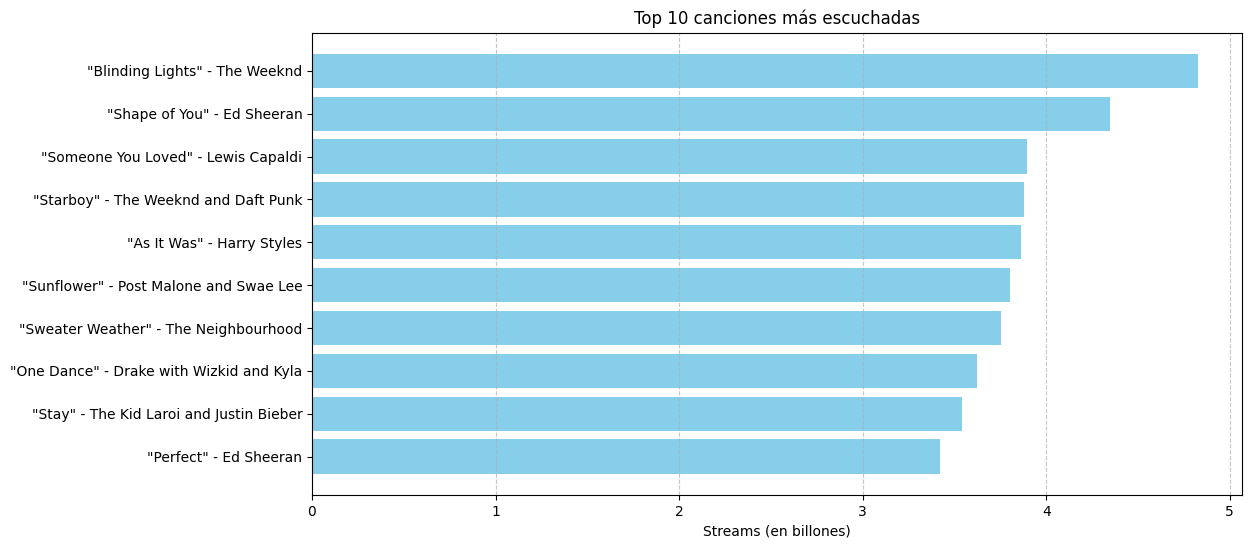

In [34]:
# Ordenar y tomar el top 10
top_10 = df.sort_values("Streams (billions)", ascending=False).head(10)

# Gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(top_10["Song"] + " - " + top_10["Artist"], top_10["Streams (billions)"], color="skyblue")
plt.xlabel("Streams (en billones)")
plt.title("Top 10 canciones más escuchadas")
plt.gca().invert_yaxis()  # Ordenar de mayor a menor
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

/tmp/ipykernel_2020/3773364546.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=artist_counts.values, y=artist_counts.index, palette="viridis")


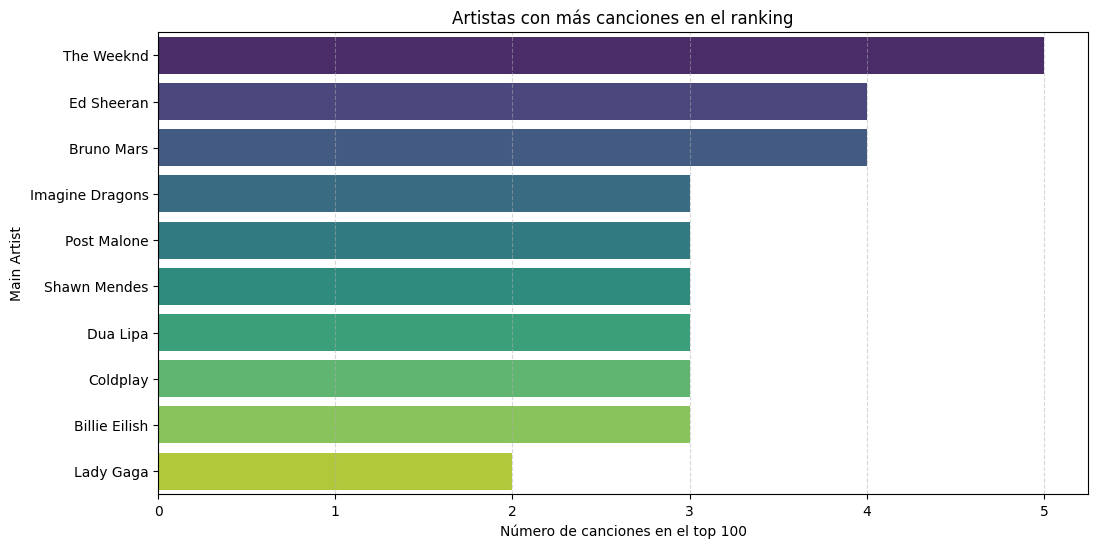

In [36]:
import seaborn as sns

# Contar canciones por artista (limpiar colaboraciones)
df["Main Artist"] = df["Artist"].str.split(" and| with| &|,").str[0]
artist_counts = df["Main Artist"].value_counts().head(10)

# Gráfico de barras (Seaborn)
plt.figure(figsize=(12, 6))
sns.barplot(x=artist_counts.values, y=artist_counts.index, palette="viridis")
plt.xlabel("Número de canciones en el top 100")
plt.title("Artistas con más canciones en el ranking")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()

/tmp/ipykernel_2020/3970396965.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Decade", y="Streams (billions)", palette="pastel")


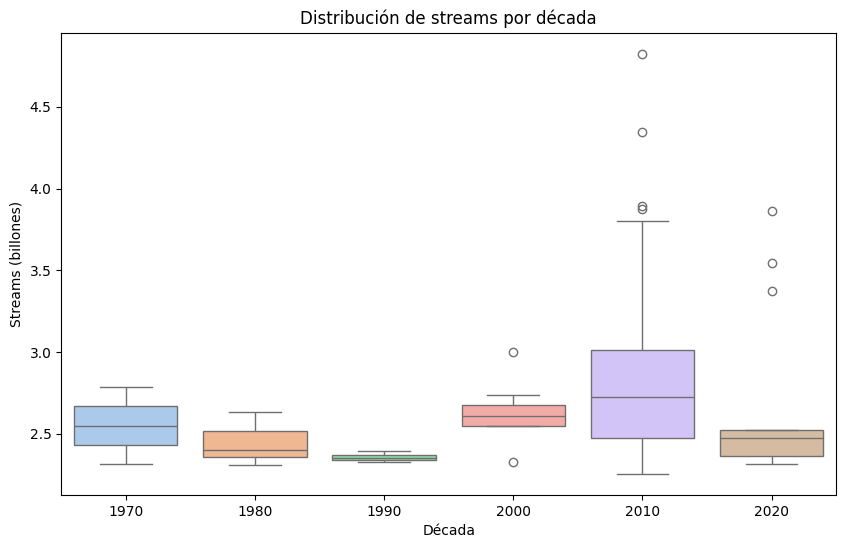

In [37]:
# Crear columnas por década
df["Decade"] = (df["Year"] // 10) * 10

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Decade", y="Streams (billions)", palette="pastel")
plt.title("Distribución de streams por década")
plt.xlabel("Década")
plt.ylabel("Streams (billones)")
plt.show()